# Hazard assessment for coastal flooding using global flood maps


- A workflow from the CLIMAAX [Handbook](https://handbook.climaax.eu/) and [FLOODS](https://github.com/CLIMAAX/FLOODS) GitHub repository.
- See our [how to use risk workflows](https://handbook.climaax.eu/notebooks/workflows_how_to.html) page for information on how to run this notebook.

## Hazard assessment methodology

In this workflow, we will map the coastal flood hazard. Coastal flooding is caused by extreme sea water levels, elevated during sea storms and increased with sea level rise. Many different methodologies can be used to arrive at a map of coastal flooding. In this workflow, we use the dataset of [Global Flood Maps](https://planetarycomputer.microsoft.com/dataset/deltares-floods) openly available via the Microsoft Planetary Computer.

In this dataset, global flood maps are available for two scenarios:
 - Present-day climate (ca. 2018).
 - Climate in 2050 under RCP8.5 climate scenario.

Within each scenario several flood maps are available, corresponding to extreme sea storms with different statistical occurence (e.g. once in 5 years, once in 100 years etc). The dataset has a relatively high spatial resolution of 30-75 m (varies with latitude). In this workflow, we retrieve the relevant parts of the coastal flood hazard dataset and explore it in more detail for the region of interest.

Before proceeding with the hazard mapping, please take a moment to learn more about the background of the coastal flood map dataset and learn what you should consider when using this dataset to assess flood risk in a local context:

`````{admonition} Dataset of coastal flood map potential and its applicability for local hazard assessment
:class: hint dropdown
The Global Flood Maps dataset was developed by Deltares based on global modelling of water levels that are affected by tides, storm surges and sea level rise. In this dataset, maps for the present climate (ca. 2018) and future climate (ca. 2050) are available, with extreme water levels corresponding to return periods of 2, 5, 10, 25, 50, 100 and 250 years. The 2050 scenario assumes sea level rise as estimated under RCP8.5 (high-emission scenario). The flood maps have a resolution of 3 arcseconds.

The methodology behind this dataset is documented and can be accessed on the ([data portal](https://planetarycomputer.microsoft.com/dataset/deltares-floods)). The dataset is based on the GTSMv3.0 (Global Tide and Surge model), forced with ERA5 reanalysis atmospheric dataset. Statistical analysis of modelled data is used to arrive at extreme water level values for different return periods. These values are used to calculate flood depths by applying static inundation modelling routine ("bathtub" method, with a simplified correction for friction over land) over a high-resolution Digital Elevation Model (MERIT-DEM or NASADEM).

Several things to take into account when interpreting the flood maps:
 - This dataset helps to understand the **coastal flood potential** at a given location. The flood modelling in this dataset does not account for man-made coastal protections that may already be in place in populated regions (e.g. dams, and storm barriers). Therefore, it is always important to survey the local circumstances when interpreting the flood maps.
 - The resolution of this global dataset is very high when considered on a global scale. However, for local areas with complex bathymetries the performance of the models is likely reduced (e.g. in estuaries or semi-enclosed bays) and the results should be treated with caution.
 - The dataset is based on a static topography. In some coastal areas, flood risk may be increased by land subsidence. If this is a known issue in the area of interest, it should be taken into account when interpreting the coastal flood maps.

For a more accurate estimate of coastal flood risks, it is recommended to perform local flood modelling, taking the results of the global model as boundary conditions. Local models can take better account of complex bathymetry and topography, and incorporate local data and knowledge about e.g. flood protection measures.
`````

## Preparation work

### Select area of interest
Before downloading the data, we will define the coordinates of the area of interest. Based on these coordinates we will be able to clip the datasets for further processing, and eventually display hazard and damage maps for the selected area.

To easily define an area in terms of geographical coordinates, you can go to the [Bounding Box Tool](https://boundingbox.klokantech.com/) to select a region and get the coordinates. Make sure to select 'CSV' in the lower left corner and copy the values in the brackets below. Next to coordinates, please specify a name for the area which will be used in plots and saved results. Note that the coordinates are specified in WGS84 coordinates (EPSG:4326).

In [1]:
## name the area for saving datasets and plots
#areaname = 'Europe' ; bbox = [-10.7,35.8,30.0,66.1]; # specify the coordinates of the bounding box
#bbox = [-1.6,46,-1.05,46.4]; areaname = 'La_Rochelle'

bbox = [12.15,44.37,12.30,44.52]; areaname = 'Barcelona'

#44.52 12.15 44.37 12.30

# Examples:
# bbox = [-1.6,46,-1.05,46.4]; areaname = 'La_Rochelle'
#bbox = [1.983871,41.252461,2.270614,41.449569]; areaname = 'Barcelona'
#bbox = [12.1,45.1,12.6,45.7]; areaname = 'Venice'
#bbox = [-9.250441,38.354403,-8.618666,38.604761]; areaname = 'Setubal'

### Load libraries

`````{admonition} Find more info about the libraries used in this workflow here
:class: hint dropdown
In this notebook, we will use the following Python libraries:
- [os](https://docs.python.org/3/library/os.html) - Provides a way to interact with the operating system, allowing the creation of directories and file manipulation.
- [numpy](https://numpy.org/) - A powerful library for numerical computations in Python, widely used for array operations and mathematical functions.
- [pandas](https://pandas.pydata.org/) - A data manipulation and analysis library, essential for working with structured data in tabular form.
- [rasterio](https://rasterio.readthedocs.io/en/stable/) - A library for reading and writing geospatial raster data, providing functionalities to explore and manipulate raster datasets.
- [xarray](https://docs.xarray.dev/en/stable/) - library for working with labelled multi-dimensional arrays.
- [rioxarray](https://corteva.github.io/rioxarray/stable/) - An extension of the xarray library that simplifies working with geospatial raster data in GeoTIFF format.
- [damagescanner](https://damagescanner.readthedocs.io/en/latest/#) - A library designed for calculating flood damages based on geospatial data, particularly suited for analyzing flood impact.
- [matplotlib](https://matplotlib.org/) - A versatile plotting library in Python, commonly used for creating static, animated, and interactive visualizations.
- [contextily](https://contextily.readthedocs.io/en/latest/) A library for adding basemaps to plots, enhancing geospatial visualizations.
- [cartopy](https://scitools.org.uk/cartopy/docs/latest/) A library for geospatial data processing.

- [planetary-computer](https://pypi.org/project/planetary-computer/) A library for interacting with the Microsoft Planetary Computer.
- [dask](https://www.dask.org/) A library for parallel computing and task scheduling.
- [pystac-client](https://pystac-client.readthedocs.io/en/stable/) A library for for working with STAC Catalogs and APIs.
- [shapely](https://shapely.readthedocs.io/en/stable/index.html) A library for manipulation and analysis of geometric objects.

These libraries collectively enable the download, processing, analysis, and visualization of geospatial and numerical data.
`````

In [2]:
!pip install -U pystac_client
!pip install -U planetary_computer
!pip install zarr
!pip install -U xarray
!pip install adlfs
!pip install netCDF4

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 182.9/182.9 kB 6.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 210.7/210.7 kB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 76.6 MB/s eta 0:00:00
  Created wheel for asciitree: filename=asciitree-0.3.3-py3-none-any.whl size=5033 sha256=38007c1b29d637f4186976bffe144587433e4f9b8f91d55ab32dfa7cca6b25e0
  Stored in directory: /root/.cache/pip/wheels/7f/4e/be/1171b40f43b918087657ec57cf3b81fa1a2e027d8755baa184
Successfully built asciitree
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.3/81.3 kB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.3/41.3 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 197.4/197.4 kB 11.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.3/55.3 kB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 405.6/405.6 kB 23.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [3]:
!pip install cartopy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 44.6 MB/s eta 0:00:00


In [7]:
!pip install rasterio
!pip install contextily

In [17]:
!pip install rioxarray
import rioxarray

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 3.3 MB/s eta 0:00:00


In [8]:
# Packages for downloading data and managing files
import os
import pystac_client
import planetary_computer

# Packages for working with numerical data and tables
import numpy as np
import pandas as pd
from dask.distributed import Client

# Packages for handling geospatial maps and data
import xarray as xr
import rasterio

# Ppackages used for plotting maps
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import matplotlib.patches as mpatches
import contextily as ctx
import cartopy.crs as ccrs

### Create the directory structure
In order for this workflow to work even if you download and use just this notebook, we need to set up the directory structure.  
Next cell will create the directory called 'FLOOD_COASTAL_hazard' in the same directory where this notebook is saved.

In [9]:
# Define the folder for the flood workflow
workflow_folder = 'FLOOD_COASTAL_hazard'

# Check if the workflow folder exists, if not, create it
if not os.path.exists(workflow_folder):
    os.makedirs(workflow_folder)

In [10]:
# Define directories for data and plots within the previously defined workflow folder
data_dir = os.path.join(workflow_folder, f'data_{areaname}')
plot_dir = os.path.join(workflow_folder, f'plots_{areaname}')

if not os.path.exists(data_dir):
    os.makedirs(data_dir)
if not os.path.exists(plot_dir):
    os.makedirs(plot_dir)

## Access and view the coastal flood map dataset

The potential coastal flood depth maps from the [Global Flood Maps dataset](https://planetarycomputer.microsoft.com/dataset/deltares-floods), are accessible remotely via API. Below we will first explore an example of a flood map from the dataset, and then load a subset of this dataset for our area of interest.

In [11]:
# prepare to connect to server - (note: comment this block out when using Binder!)
client = Client(processes=False)
print(client.dashboard_link)

INFO:distributed.http.proxy:To route to workers diagnostics web server please install jupyter-server-proxy: python -m pip install jupyter-server-proxy
INFO:distributed.scheduler:State start
INFO:distributed.scheduler:  Scheduler at: inproc://172.28.0.12/448/1
INFO:distributed.scheduler:  dashboard at:  http://172.28.0.12:8787/status
INFO:distributed.scheduler:Registering Worker plugin shuffle
INFO:distributed.worker:      Start worker at: inproc://172.28.0.12/448/4
INFO:distributed.worker:         Listening to:          inproc172.28.0.12
INFO:distributed.worker:          Worker name:                          0
INFO:distributed.worker:         dashboard at:          172.28.0.12:38985
INFO:distributed.worker:Waiting to connect to: inproc://172.28.0.12/448/1
INFO:distributed.worker:-------------------------------------------------
INFO:distributed.worker:              Threads:                          2
INFO:distributed.worker:               Memory:                  12.67 GiB
INFO:distrib

http://172.28.0.12:8787/status


In [12]:
# establish connection and search for floodmaps
catalog = pystac_client.Client.open(
    "https://planetarycomputer.microsoft.com/api/stac/v1",
    modifier=planetary_computer.sign_inplace,
)
search = catalog.search(
    collections=["deltares-floods"],
    query={
        "deltares:dem_name": {"eq": "MERITDEM"},         # option to select the underlying DEM (MERITDEM or NASADEM, use MERITDEM as default)
        "deltares:resolution": {"eq": '90m'}})           # option to select resolution (recommended: 90m)

# Print the all found items:
#for item in search.items():
#    print(item.id)

# Print the first item
print(next(search.items()))

# count the number of items
items = list(search.items())
print("Number of items found: ",len(items))

<Item id=MERITDEM-90m-2050-0250>
Number of items found:  16


In the cell above, connection to the server was made and a list of all items that match our search was retrieved. Here the search was restricted to one Digital Elevation Model (MERIT-DEM) with high-resolution maps (90 m at equator).
The first item of the list was printed to check correctness of the search, displaying the "item ID" in the format of *{DEM name}-{resolution}-{year}-{return period}*.
The total number of records is also printed, which includes all available combinations of scenario years (2018 or 2050) and extreme water level return periods.

Now we will select the first item as an example and process it to view the flood map.

In [13]:
# select first item from the search and open the dataset
item = next(search.items())
url = item.assets["index"].href
ds = xr.open_dataset(f"reference::{url}", engine="zarr", consolidated=False, chunks={})

We have opened the first dataset. The extent of the dataset is global, therefore the number of points along latitude and longitude axes is very large. This dataset needs to be clipped to our area of interest and reprojected to local coordinates (to view the maps with distances indicated in meters instead of degrees latitude/longitude).

We can view the contents of the raw dataset. It contains inundation depth (*inun* variable) defined over a large global grid.

In [14]:
ds

<xarray.Dataset> Size: 373GB
Dimensions:     (time: 1, lat: 216000, lon: 432000)
Coordinates:
  * lat         (lat) float64 2MB -90.0 -90.0 -90.0 -90.0 ... 90.0 90.0 90.0
  * lon         (lon) float64 3MB -180.0 -180.0 -180.0 ... 180.0 180.0 180.0
  * time        (time) datetime64[ns] 8B 2010-01-01
Data variables:
    inun        (time, lat, lon) float32 373GB dask.array<chunksize=(1, 4000, 4000), meta=np.ndarray>
    projection  object 8B ...
Attributes:
    Conventions:  CF-1.6
    config_file:  /mnt/globalRuns/watermask_post_MERIT/run_rp0250_slr2050/coa...
    institution:  Deltares
    project:      Microsoft Planetary Computer - Global Flood Maps
    references:   https://www.deltares.nl/en/
    source:       Global Tide and Surge Model v3.0 - ERA5
    title:        GFM - MERIT DEM 90m - 2050 slr - 0250-year return level

Now we will clip the dataset to a wider area around the region of interest, and call it *ds_local*. The extra margin is added to account for reprojection at a later stage. The clipping of the dataset allows to reduce the total size of the dataset so that it can be loaded into memory for faster processing and plotting.

In [15]:
ds_local = ds.sel(lat=slice(bbox[1]-0.5,bbox[3]+0.5), lon=slice(bbox[0]-0.5,bbox[2]+0.5),drop=True).squeeze(); del ds
ds_local.load()

<xarray.Dataset> Size: 8MB
Dimensions:     (lat: 1381, lon: 1380)
Coordinates:
  * lat         (lat) float64 11kB 43.87 43.87 43.87 43.87 ... 45.02 45.02 45.02
  * lon         (lon) float64 11kB 11.65 11.65 11.65 11.65 ... 12.8 12.8 12.8
    time        datetime64[ns] 8B 2010-01-01
Data variables:
    inun        (lat, lon) float32 8MB 0.0 0.0 0.0 0.0 0.0 ... nan nan nan nan
    projection  object 8B nan
Attributes:
    Conventions:  CF-1.6
    config_file:  /mnt/globalRuns/watermask_post_MERIT/run_rp0250_slr2050/coa...
    institution:  Deltares
    project:      Microsoft Planetary Computer - Global Flood Maps
    references:   https://www.deltares.nl/en/
    source:       Global Tide and Surge Model v3.0 - ERA5
    title:        GFM - MERIT DEM 90m - 2050 slr - 0250-year return level

We will convert the dataset to a geospatial array (with a reference to geographical coordinate system), drop the unnecessary coordinates, reproject the array to the projected coordinate system for Europe (in meters), and, finally, clip it to the region of interest using our bounding box.

In [18]:
ds_local.rio.write_crs(ds_local.projection.EPSG_code, inplace=True)
ds_local = ds_local.drop_vars({"projection","time"})
ds_local = ds_local.rio.reproject("epsg:3035")
ds_local = ds_local.rio.clip_box(*bbox, crs="EPSG:4326")

We can now plot the dataset to view the flood map for one scenario and return period. You can adjust the bounds of the colorbar by changing the *vmax* variable to another value (in meters).

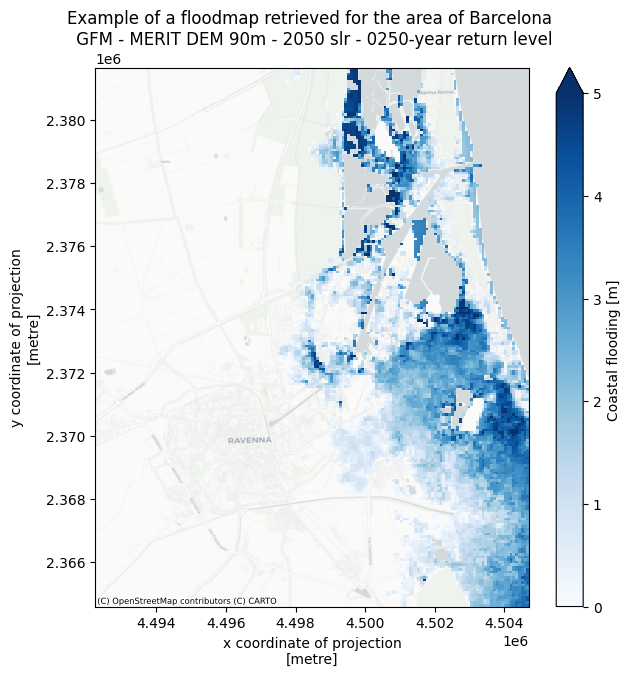

In [19]:
fig, ax = plt.subplots(figsize=(7, 7))
bs=ds_local.where(ds_local.inun>0)['inun'].plot(ax=ax,cmap='Blues',alpha=1,vmin=0,vmax=5)
ctx.add_basemap(ax=ax,crs='EPSG:3035',source=ctx.providers.CartoDB.Positron, attribution_size=6)
plt.title(f'Example of a floodmap retrieved for the area of {areaname} \n {ds_local.attrs["title"]}',fontsize=12);

## Download the coastal flood map dataset for different scenarios and return periods
In our hazard and risk assessments, we would like to be able to compare the flood maps for different scenarios and return periods. For this, we will load and merge the datasets for different scenarios and return periods in one dataset, where the flood maps can be easily accessed. Below a function is defined which contains the steps described above for an individual dataset.

In [20]:
# combine the above steps into a function to load flood maps per year and return period
def load_floodmaps(catalog,year,rp):
    search = catalog.search(
    collections=["deltares-floods"],
    query={
        "deltares:dem_name": {"eq": "MERITDEM"},
        "deltares:resolution": {"eq": '90m'},
        "deltares:sea_level_year": {"eq": year},
        "deltares:return_period": {"eq": rp}})
    item=next(search.items())
    url = item.assets["index"].href
    ds = xr.open_dataset(f"reference::{url}", engine="zarr", consolidated=False, chunks={})
    ds_local = ds.sel(lat=slice(bbox[1]-0.5,bbox[3]+0.5), lon=slice(bbox[0]-0.5,bbox[2]+0.5),drop=True).squeeze(); del ds
    ds_local.load()
    ds_local.rio.write_crs(ds_local.projection.EPSG_code, inplace=True)
    ds_local = ds_local.drop_vars({"projection","time"})
    ds_local = ds_local.rio.reproject("epsg:3035")
    ds_local = ds_local.rio.clip_box(*bbox, crs="EPSG:4326")
    ds_local = ds_local.assign_coords(year=year); ds_local = ds_local.expand_dims('year') # write corresponding scenario year in the dataset coordinates
    ds_local = ds_local.assign_coords(return_period=rp); ds_local = ds_local.expand_dims('return_period') # write corresponding return period in the dataset coordinates
    ds_floodmap = ds_local.where(ds_local.inun > 0); del ds_local
    return ds_floodmap

We can now apply this function, looping over the two scenarios and a selection of return periods.

In the Global Flood Maps dataset there are two climate scenarios: present day (represented by the year 2018) and future (year 2050, with sea level rise corresponding to the high-emission scenario, RCP8.5).
The available return periods range between 2 years and 250 years. Below we make a selection that includes 5, 10, 50, 100-year return periods).

In [21]:
# load all floodmaps in one dataset
years = [2018,2050] # list of scenario years (2018 and 2050)
rps = [2,5,10,50,100,250] # list of return periods (all: 2,5,10,25,50,100,250 yrs)
for year in years:
    for rp in rps:
        ds = load_floodmaps(catalog,year,rp)
        if (year==years[0]) & (rp==rps[0]):
            floodmaps = ds
        else:
            floodmaps = xr.merge([floodmaps,ds],combine_attrs="drop_conflicts")
        del ds

INFO:distributed.core:Event loop was unresponsive in Worker for 7.77s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
INFO:distributed.core:Event loop was unresponsive in Scheduler for 7.77s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
INFO:distributed.core:Event loop was unresponsive in Worker for 3.40s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
INFO:distributed.core:Event loop was unresponsive in Scheduler for 3.40s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
INFO:distributed.core:Event loop was unresponsive in Scheduler for 3.20s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cau

The *floodmaps* variable now contains the flood maps for different years and scenarios. We can view the contents of the variable:

In [22]:
floodmaps

<xarray.Dataset> Size: 2MB
Dimensions:        (x: 155, y: 212, year: 2, return_period: 6)
Coordinates:
  * x              (x) float64 1kB 4.492e+06 4.492e+06 ... 4.505e+06 4.505e+06
  * y              (y) float64 2kB 2.382e+06 2.382e+06 ... 2.365e+06 2.365e+06
  * year           (year) int64 16B 2018 2050
  * return_period  (return_period) int64 48B 2 5 10 50 100 250
    spatial_ref    int64 8B 0
Data variables:
    inun           (return_period, year, y, x) float32 2MB nan nan ... 3.845
Attributes:
    Conventions:  CF-1.6
    institution:  Deltares
    project:      Microsoft Planetary Computer - Global Flood Maps
    references:   https://www.deltares.nl/en/
    source:       Global Tide and Surge Model v3.0 - ERA5

## Visualize coastal flood hazard dataset
Now we can compare the maps of flood potential in different scenarios and with different return periods. We will plot the maps next to each other:

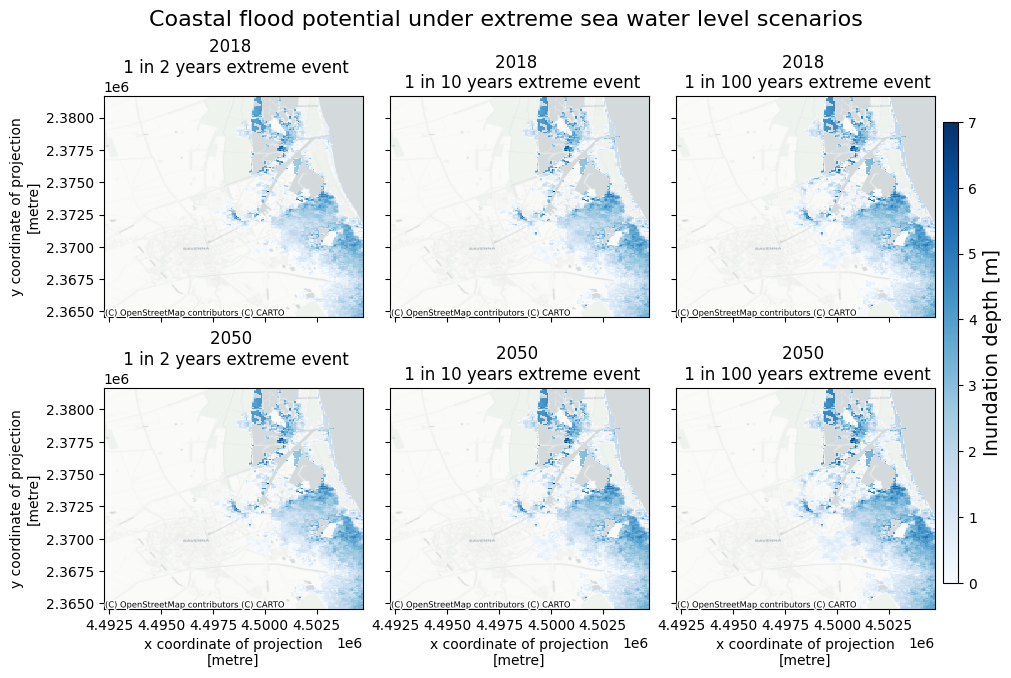

In [23]:
# define upper limit for inundation depth for plotting
inun_max = 7 # np.nanmax(floodmaps.sel(year=2050,return_period=250)['inun'].values)

# select return periods to plot
rps_sel = [2,10,100]

fig,axs = plt.subplots(figsize=(10, 10/len(rps_sel)*2),nrows=len(years),ncols=len(rps_sel),constrained_layout=True,sharex=True,sharey=True)

for yy,year in enumerate(years):
    for rr,rp in enumerate(rps_sel):

        bs=floodmaps.sel(year=year,return_period=rp)['inun'].plot(ax=axs[yy,rr], vmin=0, vmax=inun_max, cmap='Blues', add_colorbar=False)

        ctx.add_basemap(axs[yy,rr],crs=floodmaps.rio.crs.to_string(),source=ctx.providers.CartoDB.Positron, attribution_size=6) # add basemap
        axs[yy,rr].set_title(f'{year} \n 1 in {rp} years extreme event',fontsize=12)
        if rr>0:
            axs[yy,rr].yaxis.label.set_visible(False)
        if yy==0:
            axs[yy,rr].xaxis.label.set_visible(False)

fig.colorbar(bs,ax=axs[:],orientation="vertical",pad=0.01,shrink=0.9,aspect=30).set_label(label=f'Inundation depth [m]',size=14)
fig.suptitle('Coastal flood potential under extreme sea water level scenarios',fontsize=16);

fileout = os.path.join(plot_dir,'Floodmap_{}_overview.png'.format(areaname))
fig.savefig(fileout)

We can visualize the differences in potential coastal flood extent by plotting two scenarios on top of each other. In the plot below we compare the flood extents for scenarios in years 2018 and 2050 (1 in 5 years and 1 in 100 years return periods). The difference between the two scenarios is attributed to sea level rise. In 2050 the sea level rise (compared to present time) is in the order of 0.2 m (you can explore sea level rise projections on the [NASA data portal](https://sealevel.nasa.gov/ipcc-ar6-sea-level-projection-tool)), which has a relatively small contribution to the extreme water levels in the global flood maps.

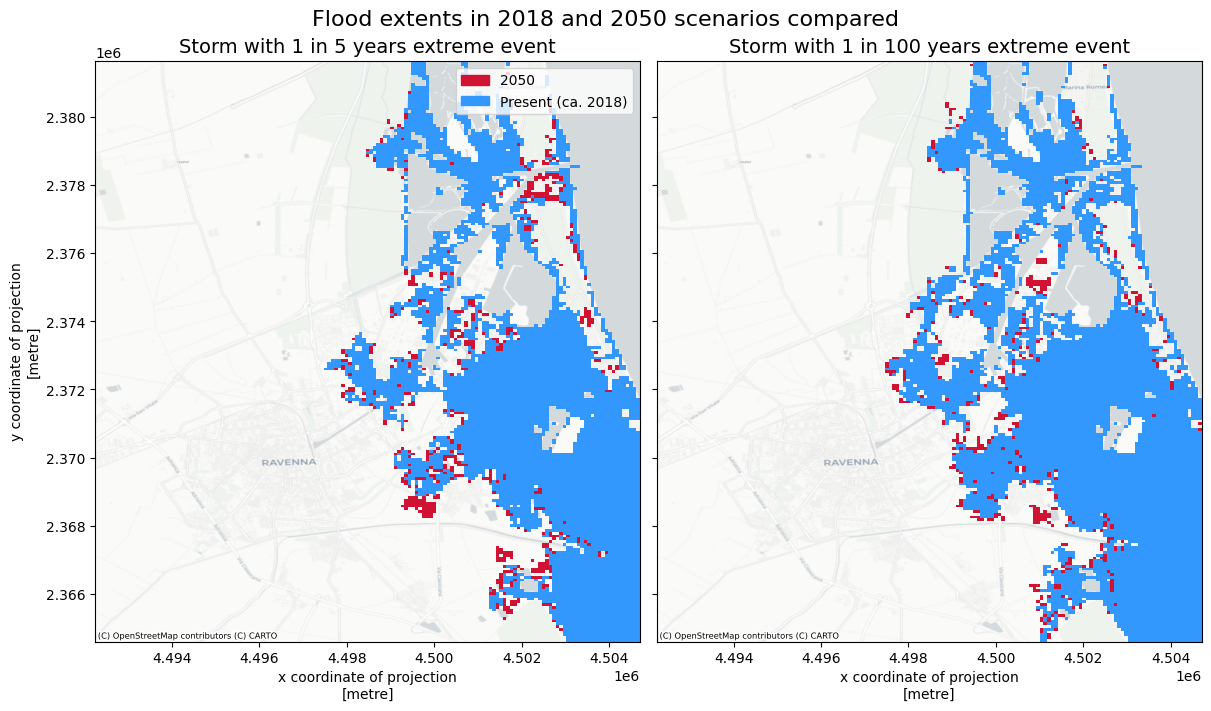

In [24]:
# Plot to compare flood extents between 2018 and 2050 scenarios
col1 = [209/256, 19/256, 51/256, 1] # define colors for plotting
col2 = [51/256, 153/256, 255/256, 1]
cmap1 = ListedColormap(np.array(col1))
cmap2 = ListedColormap(np.array(col2))

# select which return periods to compare (2 periods)
rps_comp = [5,100]

fig,axs = plt.subplots(figsize=(12, 7),nrows=1,ncols=len(rps_comp),constrained_layout=True,sharex=True,sharey=True)

for ii,rp in enumerate(rps_comp):
    floodmaps.sel(year=2050,return_period=rp)['inun'].plot(ax=axs[ii],cmap=cmap1,add_colorbar=False); p1 = mpatches.Patch(color=col1, label='2050')
    floodmaps.sel(year=2018,return_period=rp)['inun'].plot(ax=axs[ii],cmap=cmap2,add_colorbar=False);  p2 = mpatches.Patch(color=col2, label='Present (ca. 2018)')
    ctx.add_basemap(axs[ii],crs=floodmaps.rio.crs.to_string(),source=ctx.providers.CartoDB.Positron, attribution_size=6) # add basemap
    axs[ii].set_title(f'Storm with 1 in {rp} years extreme event',fontsize=14);
    if ii==0:
        axs[ii].legend(handles=[p1,p2])
    else:
        axs[ii].yaxis.label.set_visible(False)

fig.suptitle('Flood extents in 2018 and 2050 scenarios compared',fontsize=16);

fileout = os.path.join(plot_dir,'Floodmap_{}_compare_2050vs2018.png'.format(areaname))
fig.savefig(fileout)

To understand the differences between the potetial coastal flood extents corresponding to different return periods, we can make also plot the flood extents for different return periods on top of each other below.

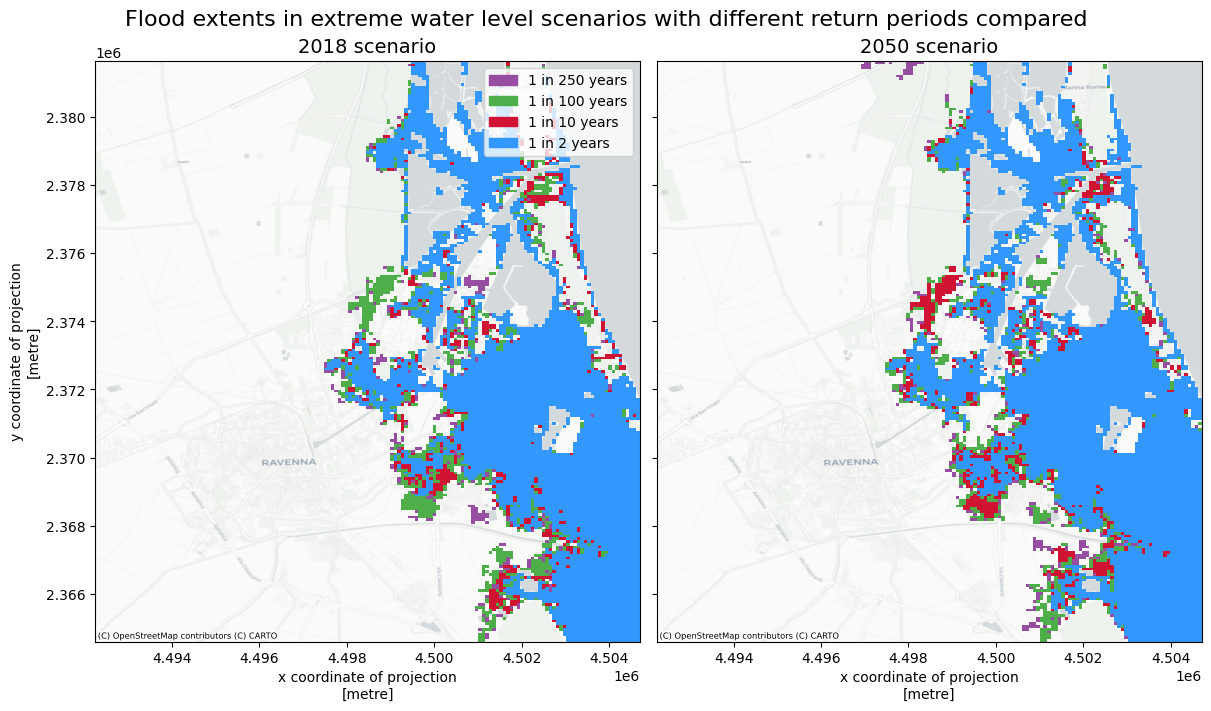

In [25]:
# Plot to compare flood extents for different return periods
colors = [[152/256, 78/256, 163/256, 1],[77/256, 175/256, 74/256, 1],[209/256, 19/256, 51/256, 1],[51/256, 153/256, 255/256, 1]]

# select which return periods to compare
rps_comp = [2,10,100,250]
scenarios = [2018,2050]

fig,axs = plt.subplots(figsize=(12, 7),nrows=1,ncols=len(scenarios),constrained_layout=True,sharex=True,sharey=True)
rps_comp.sort(reverse=True)
for ii, scenario in enumerate(scenarios):
    ph=[]
    for rr,rp in enumerate(rps_comp):
        floodmaps.sel(year=scenario,return_period=rp)['inun'].plot(ax=axs[ii],cmap=ListedColormap(np.array(colors[rr])) ,add_colorbar=False); ph.append(mpatches.Patch(color=colors[rr], label=f'1 in {rp} years'))
    ctx.add_basemap(axs[ii],crs=floodmaps.rio.crs.to_string(),source=ctx.providers.CartoDB.Positron, attribution_size=6) # add basemap
    axs[ii].set_title(f'{scenario} scenario',fontsize=14);
    if ii==0:
        axs[ii].legend(handles=ph)
    else:
        axs[ii].yaxis.label.set_visible(False)

fig.suptitle('Flood extents in extreme water level scenarios with different return periods compared',fontsize=16);

fileout = os.path.join(plot_dir,'Floodmap_{}_compare_return_periods.png'.format(areaname))
fig.savefig(fileout)

## Save dataset to a local directory for future access
Now that we have loaded the full dataset, we will save it to a local folder to be able to easily access it later. There are two options for saving the dataset: as a single netCDF file containing all scenarios, and as separate raster files (**.tif** format).

In [ ]:
# save the full dataset to netCDF file
fileout = os.path.join(data_dir,f'floodmaps_all_{areaname}.nc')
floodmaps.to_netcdf(fileout); del fileout

In [ ]:
# save individual flood maps to raster files
for year in years:
    for rp in rps:
        floodmap_file = os.path.join(data_dir, f'floodmap_{areaname}_{year}_{rp:04}.tif')
        da = floodmaps['inun'].sel(year=year,return_period=rp,drop=True) # select data array

        with rasterio.open(floodmap_file,'w',driver='GTiff',
            height=da.shape[0],
            width=da.shape[1],
            count=1,dtype=str(da.dtype),
            crs=da.rio.crs, transform=da.rio.transform()) as dst:
            dst.write(da.values,indexes=1) # Write the data array values to the rasterio dataset

## Conclusions

In this hazard workflow we learned:
 - How to retrieve coastal flood maps for your specific region.
 - Understanding the accuracy of coastal flood maps and their applicability for local context.
 - Understanding the differences between scenarios and return periods.

The coastal flood hazard maps that were retrieved and saved locally in this workflow will be further used in the coastal flood risk workflow (part of the risk toolbox).



## Contributors

Applied research institute Deltares (The Netherlands).

Authors of the workflow:
Natalia Aleksandrova

Global Flood Maps dataset documentation can be found [here](https://planetarycomputer.microsoft.com/dataset/deltares-floods).

